In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import pickle

In [2]:
df = pd.read_csv("../../data/processed/bank-dataset-processed.csv",index_col=0)

In [3]:
# Features and target
X = df.drop('y', axis=1)
y = df['y']

In [4]:
# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Feature scaling (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [7]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=42), 
                           param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [8]:
print(f'Best Parameters: {grid_search.best_params_}')
rf_best = grid_search.best_estimator_
y_pred = rf_best.predict(X_test_scaled)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9032
Confusion Matrix:
[[7617  335]
 [ 540  551]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      7952
         1.0       0.62      0.51      0.56      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.73      0.75      9043
weighted avg       0.90      0.90      0.90      9043



In [9]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.6219
Recall: 0.5050
F1-score: 0.5574


In [10]:
# Calculate AUC-ROC score
y_prob = rf_best.predict_proba(X_test)[:, 1]  # Probability of class 1
auc_roc = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC: {auc_roc:.4f}')

AUC-ROC: 0.4992


/Users/vjaiwantx/coursework/sem2/predictive/bank-marketing-predictor/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


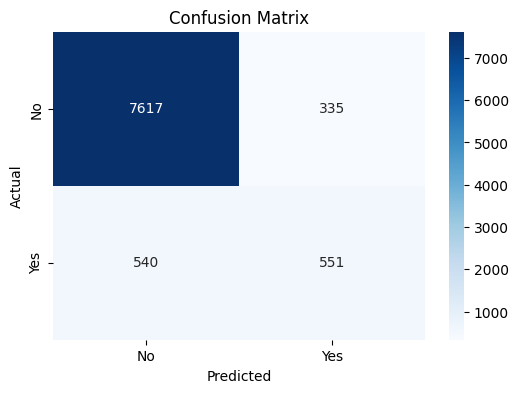

In [11]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Get feature importances
importances = rf_best.feature_importances_
feature_names = X.columns

In [13]:
# Put in dataframe
rf_feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

In [14]:
# Sort by importance
rf_feature_importance = rf_feature_importance.sort_values(by="Importance", ascending=False)
print(rf_feature_importance)

      Feature  Importance
11   duration    0.388595
10      month    0.088260
5     balance    0.083734
0         age    0.082690
9         day    0.070384
13      pdays    0.057427
8     contact    0.039838
6     housing    0.038745
1         job    0.036342
12   campaign    0.033366
14   previous    0.030279
3   education    0.020931
2     marital    0.016996
7        loan    0.010874
4     default    0.001539


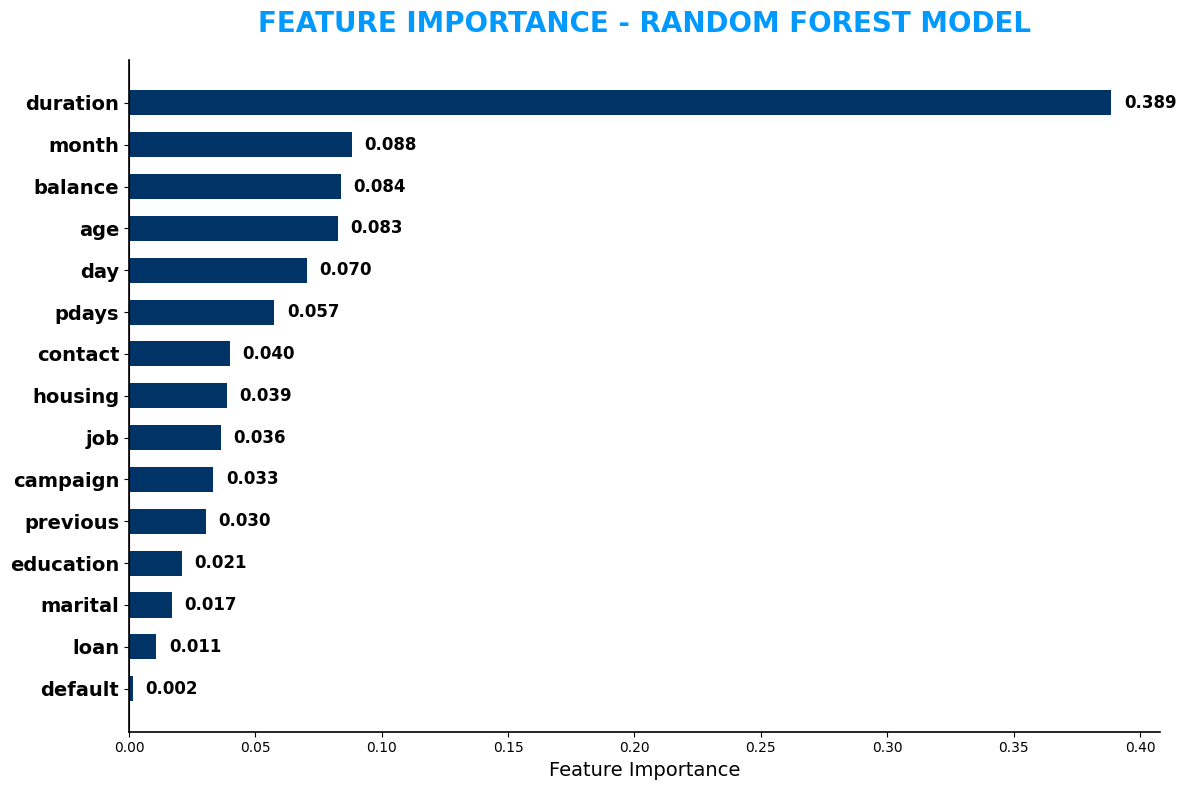

In [21]:
# Sort the data by importance descending
rf_feature_importance_sorted = rf_feature_importance.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
y = np.arange(len(rf_feature_importance_sorted))
bar_width = 0.6

# Color styling (dark blue to light blue)
bars = ax.barh(y, rf_feature_importance_sorted['Importance'], height=bar_width, color='#003366')

# Add values on the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2,
            f"{width:.3f}", va='center', ha='left', 
            color='black', fontsize=12, fontweight='bold')

# Y-axis labels
ax.set_yticks(y)
ax.set_yticklabels(rf_feature_importance_sorted['Feature'], fontsize=14, fontweight='bold')

# Styling like Statista
ax.set_xlabel('Feature Importance', fontsize=14)
ax.axvline(0, color='black', linewidth=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Statista-like title
ax.set_title('FEATURE IMPORTANCE - RANDOM FOREST MODEL', fontsize=20, 
             fontweight='bold', color='#0099ff', pad=20, loc='center')

plt.tight_layout()
plt.savefig("../plots/feature-importance.png")
plt.show()


# Testing to train model by balancing data using SMOTE


In [16]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE on training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [17]:
# Let's check the new class distribution
from collections import Counter
print(Counter(y_train_smote))

Counter({0.0: 31970, 1.0: 31970})


In [18]:
# Create a pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__class_weight': ['balanced', None]  # You can also tune class_weight if needed
}

In [19]:
# Use GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [ ]:
# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

In [ ]:
# Assuming rf_model is your trained RandomForestClassifier
with open('models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)